### DISTRIBUITED ALGORITHMS - K-MEANS||

Vladimir Ungureanu - 2141678

Yusuf Kenan Şafak - 2141676

Javlonbek Jamilov - 2162284

The purpose of this project is to implement parallel K-Means algorithm using Dask, and to test its performance with different hyperparameters in a distributed system.

The performance test is done on KDD Cup 1999 dataset.

# Cluster Setup

- As the nodes of our cluster we used 3 VMs that each had 4 VCPUs, 8 GB of RAM and a 25GB disk memory

 

Before everything becomes pythonic we had to go through some important configuration steps:
- Create matching conda enviroments on all machines to ensure compatibility
- Install all necessary libraries
- Install and start a Jupyter-Notebook enviroment on VM1
- Create tunnels between the local machine and VM1 for: Jupyter-notebook, Dask scheduler and Dask dashboard

In [1]:
import dask.array as da
from dask.distributed import Client
from dask.distributed import performance_report
from dask_ml.preprocessing import StandardScaler
from dask_ml.cluster import KMeans
import numpy as np
from dask_ml.metrics import pairwise_distances, pairwise_distances_argmin_min
from time import time
from timeit import default_timer as now
from dask_ml.datasets import make_blobs
import pandas as pd
from dask.distributed import SSHCluster
import matplotlib.pyplot as plt
import getpass
from sklearn.datasets import fetch_kddcup99
from itertools import product
from tqdm.auto import tqdm
import pickle, pathlib

In [ ]:
hosts = [
    "10.67.22.199",
    "10.67.22.199",   # VM 1  – will run the scheduler *and* a worker
    "10.67.22.138",   # VM 2  – workers only
    "10.67.22.85"    # VM 3  – workers only
]
cluster = SSHCluster(
        hosts,
        connect_options={
            "username": "ungureanu",       
            "password": getpass.getpass("SSH password:"),
            "known_hosts": None,
        },
        remote_python="/opt/miniconda3/envs/dask-env/bin/python", 
        scheduler_options={
            "port": 8786,
            "dashboard_address":":8787",
        },
        worker_options={
            "n_workers": 1,        
            "nthreads": 4,      
            "memory_limit": "7.8GB"
        },
        
    )
    
client = Client(cluster)
client

In [ ]:
scheduler_info = client.scheduler_info()
workers_info = scheduler_info['workers'] 
worker = list(workers_info.values())[0]
n_workers = len(workers_info)
n_threads = worker['nthreads']

print(f'client dashboard link: {client.dashboard_link}')
print(f"Cluster setup with {n_workers} workers, each with {n_threads} threads")

Cluster setup with 3 workers(1 on each VM), each with 4 threads.

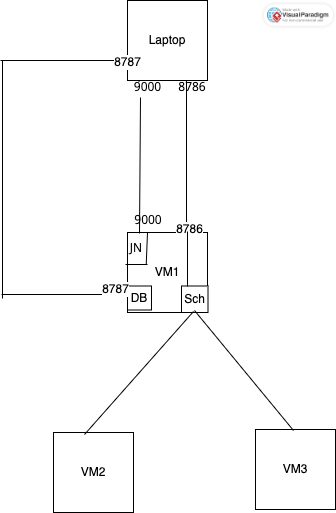

# K-means||

K-Means is a popular method for grouping data without predefined categories. While K-Means++ is a common way to set up the starting points for K-Means, it works step-by-step. To handle large datasets more efficiently, a parallel version called K-Means|| has been developed (https://arxiv.org/abs/1203.6402). 

This parallel approach improves upon K-Means++ by spreading out calculations among many processors, allowing for faster processing and quicker results on big data. The main innovation of this method is its enhanced initial setup, after which it uses a scalable version of the standard K-Means process (Lloyd's algorithm) to finalize the clusters.


**K-Means|| Algorithm**

**Input**: Dataset $X$, number of clusters $k$, oversampling factor $l$, iterations $t$.

**Output**: $k$ final cluster centroids $C$.

**Steps**:

1.  **Initialize**: Randomly pick one point from $X$ as the first centroid, forming $C=\{c_1\}$.
2.  **Compute Cost**: Calculate $\psi$, the sum of squared distances from all points in $X$ to their nearest centroid in $C$.
3.  **Sample**: Repeat $O(\log \psi)$ times: sample points from $X$ with probability proportional to their squared distance from existing centroids in $C$. Add sampled points to $C$. (Size of $C$ becomes $O(\ell \cdot \log \psi)$).
4.  **Recluster**: Weight points in $C$ by how many original data points are closest to them. Recluster these weighted points in $C$ into $k$ final centroids using a K-Means++ initialized Lloyd's algorithm.

**K-Means++ Algorithm (for K-Means|| Reclustering)**

**Steps**:

1.  **Initialize**: Randomly select one point from the *current set of potential centroids* (from K-Means||'s step 3, which is $C$) as the first centroid. This forms your initial centroid set.
2.  **Calculate Nearest Centroid Distances**: For every remaining point in the potential centroid set, determine its squared distance to the closest centroid already chosen.
3.  **Select Next Centroid**: Choose the next centroid probabilistically: points farther from existing centroids have a higher chance of being selected (probability $p(x) = D(x)^2 / \sum D(x_i)^2$).
4.  **Repeat**: Continue steps 2 and 3 until $k$ centroids are selected. Update distances $D(x)$ each time a new centroid is added.
5.  **Finalize**: Proceed with standard Lloyd's K-Means iterations using these $k$ chosen centroids.

**Lloyd's K-Means Algorithm**

**1. Centroid Setup**
   The process starts by setting up $k$ initial cluster centers ($\mu_1, \dots, \mu_k$). These can be chosen randomly or using a more advanced method like K-means++.

**2. Point-to-Centroid Allocation**
   Each data point $x_i$ in the dataset $X$ is assigned to the cluster whose centroid is closest to it. This assignment $c(i)$ is determined by finding the centroid $\mu_j$ that minimizes the squared Euclidean distance:
   $c(i) = \arg \min_{j \in \{1, \dots, k\}} \| x_i - \mu_j \|^2$

**3. Centroid Relocation**
   After all points are assigned, each centroid is moved to the average position of all the points currently assigned to its cluster. The new centroid $\mu_j$ for cluster $j$ (containing points $C_j$) is calculated as:
   $\mu_j = \frac{1}{|C_j|} \sum_{x_i \in C_j} x_i$

**4. Iteration and Completion**
   Steps 2 and 3 are repeated. The algorithm stops when the centroids no longer move much between iterations (converge) or a set maximum number of iterations is reached.
   The algorithm's goal is to minimize the total squared distance of points to their assigned cluster centroids:
   $\text{Objective: } \sum_{j=1}^k \sum_{x_i \in C_j} \| x_i - \mu_j \|^2$

In [2]:
def total_min_distance(data, centroids):
    distances = pairwise_distances(data, centroids, metric='sqeuclidean')
    return distances.min(axis=1).sum().compute()

def initial_candidate_selection(data, num_clusters, oversampling_factor):
    num_points, _ = data.shape
    seed_idx = np.random.choice(num_points, size=1)
    centroid_pool = data[seed_idx].compute()

    init_cost = total_min_distance(data, centroid_pool)
    num_rounds = int(np.log(init_cost + 1e-6))  # Avoid log(0)

    for _ in range(num_rounds):
        dist_sq = pairwise_distances(data, centroid_pool, metric='sqeuclidean').min(axis=1)
        prob_dist = (oversampling_factor * dist_sq / dist_sq.sum()).compute()
        #random_values = da.random.random(size=len(prob_dist), chunks=prob_dist.chunks)
        
        chunk_size = int(np.ceil(len(prob_dist) / 12))
        random_values = da.random.random(size=len(prob_dist), chunks=(chunk_size,))
        
        selected_mask = random_values < prob_dist
        selected_indices = da.where(selected_mask)[0].compute()
        new_centroids = data[sorted(selected_indices)].compute()
        centroid_pool = np.vstack([centroid_pool, new_centroids])

    return centroid_pool

def compute_assignment_weights(data, centroids):
    distances = pairwise_distances(data, centroids, metric='euclidean')
    closest_indices = da.argmin(distances, axis=1)
    counts = da.bincount(closest_indices, minlength=len(centroids)).compute()
    weight_sum = counts.sum()
    if weight_sum == 0:
        return np.ones(len(centroids)) / len(centroids)
    cluster_weights = counts / weight_sum
    return cluster_weights

def kmeans_plus_plus_weighted_init(data, cluster_weights, num_clusters):
    num_points, _ = data.shape
    seed_idx = np.random.choice(num_points, size=1)
    centers = data[seed_idx].compute()

    for _ in range(1, num_clusters):
        dist_sq = pairwise_distances(data, centers, metric='sqeuclidean').min(axis=1) * cluster_weights
        prob = dist_sq / dist_sq.sum()
        new_idx = np.random.choice(num_points, size=1, p=prob.compute())
        new_center = data[sorted(new_idx)].compute()
        centers = np.vstack([centers, new_center])

    return centers

def assign_to_centroids(data, centers):
    cluster_labels, _ = pairwise_distances_argmin_min(data, centers, metric='sqeuclidean')
    return cluster_labels

def weighted_centroid_update(data, cluster_labels, cluster_weights, num_clusters):
    updated = []
    for cluster_id in range(num_clusters):
        cluster_mask = cluster_labels == cluster_id
        cluster_data = data[cluster_mask]
        weight_subset = cluster_weights[cluster_mask]
        if cluster_data.shape[0] == 0:
            continue
        cluster_mean = da.average(cluster_data, axis=0, weights=weight_subset)
        updated.append(cluster_mean)
    return da.stack(updated)

def run_lloyds(data, cluster_weights, num_clusters, max_iter=100, tolerance=1e-8):
    centroids = kmeans_plus_plus_weighted_init(data, cluster_weights, num_clusters)

    for _ in range(max_iter):
        cluster_labels = assign_to_centroids(data, centroids).compute()
        new_centroids = weighted_centroid_update(data, cluster_labels, cluster_weights, num_clusters).compute()
        if da.allclose(new_centroids, centroids, atol=tolerance).compute():
            break
        centroids = new_centroids
    return cluster_labels, centroids

def run_distributed_kmeans(data, num_clusters, max_iter=100, tolerance=1e-8, oversample_factor=2):
    candidate_centroids = initial_candidate_selection(data, num_clusters, oversample_factor)
    cluster_weights = compute_assignment_weights(data, candidate_centroids)
    dask_centroids = da.from_array(candidate_centroids, chunks=(candidate_centroids.shape[0], candidate_centroids.shape[1]))
    cluster_labels, centroids = run_lloyds(dask_centroids, cluster_weights, num_clusters, max_iter, tolerance)
    
    for _ in range(max_iter):
        cluster_labels = assign_to_centroids(data, centroids)
        new_centroids = da.stack([data[cluster_labels == i].mean(axis=0) for i in range(num_clusters)]).compute()
        if da.allclose(centroids, new_centroids, atol=tolerance).compute():
            break
        centroids = new_centroids

    return cluster_labels, centroids

### Test on Synthetic Data

In [ ]:
n_samples = 5000000*2.5
n_features = 50
centers = 5
random_state = 42
chunks = (n_samples//23,n_features) 
synt_data, true_labels = make_blobs(n_samples=n_samples, n_features=n_features, 
                               centers=centers, chunks=chunks)
synt_data

In [ ]:
scaler = StandardScaler(with_mean=True) # for scaling with a sparse matrix
%time synt_normalized = scaler.fit_transform(synt_data)
del synt_data

In [ ]:
from dask.distributed import performance_report
k = centers  # Number of clusters

with performance_report(filename="kmean_our.html"):  
    %time synt_labels, synt_centroids = run_distributed_kmeans(synt_normalized, k, 2)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

subset = int(synt_normalized.shape[0]/10000)

# Kmeans labels plot
ax[0].scatter(synt_normalized[:subset, 0], synt_normalized[:subset, 1], c=synt_labels[:subset], cmap='viridis')
ax[0].scatter(synt_centroids[:, 0], synt_centroids[:, 1], c='red', marker='x', s=100)
ax[0].set_title('K-means clustering with Dask')

# True labels plot
ax[1].scatter(synt_normalized[:subset, 0], synt_normalized[:subset, 1], c=true_labels[:subset], cmap='viridis')
ax[1].scatter(synt_centroids[:, 0], synt_centroids[:, 1], c='red', marker='x', s=100)
ax[1].set_title('True labels')

plt.show()

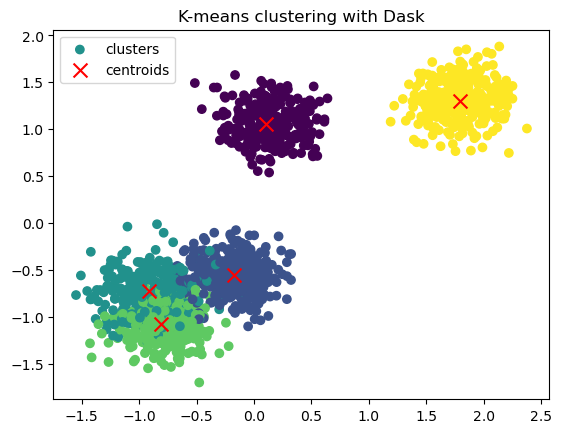

In [ ]:
cluster.close()
client.close()

## KDDCUP Dataset Performance Benchmarking

The KDD Cup 1999 dataset was created for a 1999 competition focused on network intrusion detection. Its purpose is to provide a rich dataset for developing models that can identify network intrusions and anomalies. Participants were challenged to build a predictive model capable of distinguishing between "bad" connections (intrusions/attacks) and "good" connections (normal network activity).

**Key characteristics of the dataset include:**

* **Size:** It comprises roughly 5 million records, split into training and testing sets.
* **Dimensionality:** Each record has 42 features describing network traffic, such as connection duration, protocol, service used, and various flags. These features are instrumental in discerning normal versus malicious behavior.
* **Classes:** The dataset is labeled with 24 distinct attack types or as "normal" traffic, making it a multi-class classification problem. These attack types are further grouped into four primary categories: **DoS** (Denial of Service), **R2L** (Remote to Local), **U2R** (User to Root), and **Probe**.

In [ ]:
raw_data = pd.read_csv('kddcup.data.gz', header=None, compression='gzip')
exclude_indices = [1, 2, 3, 41]

numerical_data = raw_data.drop(columns=raw_data.columns[exclude_indices])

total_entries = numerical_data.shape[0]
sample_fraction = 0.8  
sample_count = int(sample_fraction * total_entries)

subset = numerical_data.iloc[:sample_count]

data = subset.to_numpy()

del raw_data, numerical_data, subset

In [ ]:
def evaluate_kmeans_performance(dataset, num_workers, threads_per_node, mem_cap, chunk_spec, repetitions):
    vm_ips = [
        "10.67.22.199",  # Acts as scheduler and worker
        "10.67.22.199",
        "10.67.22.138",
        "10.67.22.85"
    ]

    ssh_creds = {
        "username": "ungureanu",
        "password": getpass.getpass("SSH password:"),
        "known_hosts": None
    }

    cluster = SSHCluster(
        hosts=vm_ips,
        connect_options=ssh_creds,
        remote_python="/opt/miniconda3/envs/dask-env/bin/python",
        scheduler_options={
            "port": 8786,
            "dashboard_address": ":8787",
        },
        worker_options={
            "n_workers": num_workers,
            "nthreads": threads_per_node,
            "memory_limit": mem_cap
        }
    )

    client = Client(cluster)
    print(client)
    print(f"\nRunning benchmark: workers={num_workers}, threads={threads_per_node}, "
          f"memory={mem_cap}, chunks={chunk_spec}")

    
    chunked_data = da.from_array(dataset, chunks=(dataset.shape[0] // chunk_spec, dataset.shape[1]))

   
    normalizer = StandardScaler(with_mean=True)
    processed_data = normalizer.fit_transform(chunked_data)
    del chunked_data  # Free memory

    processed_data = processed_data.persist()  

    n_clusters = 4

    timing = []
    for _ in range(repetitions):
        tic = now()
        labels, centroids = run_distributed_kmeans(processed_data, n_clusters, 2)
        toc = now()
        timing.append(toc - tic)

    mean_time = np.mean(timing)
    std_time = np.std(timing)


    print(f"KMeans Avg: {mean_time:.2f}s ± {std_time:.2f}s")

    summary = {
        'workers': num_workers,
        'threads': threads_per_node,
        'memory_limit': mem_cap,
        'chunks': chunk_spec,
        'kmeans_mean_time': mean_time,
        'kmeans_std_time': std_time
    }

    client.close()
    cluster.close()

    return summary


The cell belows loop through some configurations and saves the performance bechmark data in pickle files.

In [ ]:
configurations = [
    {'workers': 1, 'threads': 4, 'mem': '7 GB'},    
    {'workers': 2, 'threads': 2, 'mem': '3.5 GB'}, 
    {'workers': 1, 'threads': 2, 'mem': '7 GB'},   
    {'workers': 2, 'threads': 1, 'mem': '3.5 GB'},  
    {'workers': 1, 'threads': 3, 'mem': '7 GB'},    
]

chunk_options = [4, 6, 8, 10, 16]

out_dir = pathlib.Path("bench_runs")
out_dir.mkdir(exist_ok=True)

for cfg, chunks in product(configurations, chunk_options):
    output = evaluate_kmeans_performance(
        dataset=data,
        num_workers=cfg["workers"],
        threads_per_node=cfg["threads"],
        mem_cap=cfg["mem"],
        chunk_spec=chunks,
        repetitions=3,
    )
    output.update(cfg, chunks=chunks)

    stamp = int(time() * 1000)         
    fname = f"w{cfg['workers']}_t{cfg['threads']}_c{chunks}_{stamp}.pkl"
    pickle.dump(output, (out_dir / fname).open("wb"))

After the data aquisition we transfered the files to our local machine.